# HW2: Training a Neural network on the mnist data

We are going to train a neural network here, like we trained a logistic regression in the class repository.

You will need to read `logistic.ipynb` and `logistic_pytorch.ipynb` in that repo for this to make any sense.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [7]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Displaying random images from the training set:


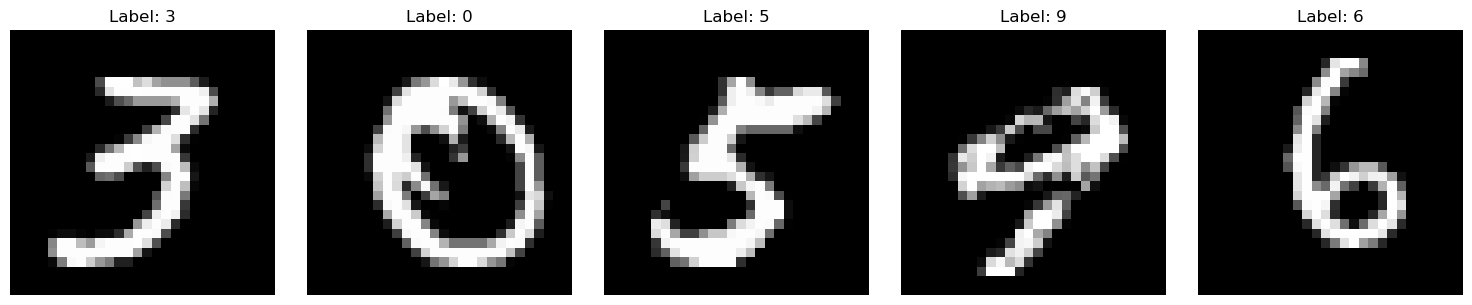

In [8]:
# Function to display random images from the dataset
def display_random_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display random images from the training set
print("Displaying random images from the training set:")
display_random_images(train_dataset)

In [9]:
# Create a full-batch loader for simple gradient descent
full_batch_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Here is our model. We do 100 linear transformations with an intercept term, on 784 inputd (all the pixels). The `x.view` flattens the 2-D pixels into a vector. Then we do the 100 linear transformations (784 slopes + 1 intercept = 785 parameters EACH!). Then we pass them through the ReLU nonlinearity (see [RELU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) for more). (otherwise everything would be a linear transform). We have 100 outputs or activations. Then we do 10 transformations to our 10 classes, at which point we apply the cross-entropy loss including a softmax.

Here is a great resource on sigmoid and softmax you should read. [https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/). Watching the 3-blue 1 brown videos again will be useful!

In [10]:
# Define the neural network model
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 100)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [11]:
# Initialize the model, loss function, and optimizer
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

`model.train()` is called at the beginning of each training epoch. This ensures that:

- If the model has dropout layers, they will be active during training.
- If the model has batch normalization layers, they will update their running statistics.

`optimizer.zero_grad()` is called at the beginning of each batch. This ensures that:

- The gradients from the previous batch don't interfere with the current batch.
- Each batch starts with a clean slate for gradient computation.


`model.eval()` is called before the evaluation phase. This ensures that:

- Dropout layers (if any) don't drop any neurons during evaluation.
- Batch normalization layers (if any) use their stored statistics instead of computing batch statistics.


`torch.no_grad()` is used during evaluation to disable gradient computation, which:

- Saves memory
- Speeds up computation
- Is appropriate since we're not updating the model during evaluation

In [12]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/20:
Train Loss: 0.3524, Train Acc: 90.21%
Val Loss: 0.3704, Val Acc: 89.56%

Epoch 2/20:
Train Loss: 0.2895, Train Acc: 91.69%
Val Loss: 0.3115, Val Acc: 90.87%

Epoch 3/20:
Train Loss: 0.2538, Train Acc: 92.72%
Val Loss: 0.2785, Val Acc: 91.97%

Epoch 4/20:
Train Loss: 0.2281, Train Acc: 93.49%
Val Loss: 0.2540, Val Acc: 92.70%

Epoch 5/20:
Train Loss: 0.2072, Train Acc: 94.21%
Val Loss: 0.2344, Val Acc: 93.27%

Epoch 6/20:
Train Loss: 0.1884, Train Acc: 94.67%
Val Loss: 0.2171, Val Acc: 93.81%

Epoch 7/20:
Train Loss: 0.1730, Train Acc: 95.13%
Val Loss: 0.2028, Val Acc: 94.17%

Epoch 8/20:
Train Loss: 0.1604, Train Acc: 95.45%
Val Loss: 0.1915, Val Acc: 94.51%

Epoch 9/20:
Train Loss: 0.1487, Train Acc: 95.87%
Val Loss: 0.1821, Val Acc: 94.67%

Epoch 10/20:
Train Loss: 0.1389, Train Acc: 96.13%
Val Loss: 0.1720, Val Acc: 94.97%

Epoch 11/20:
Train Loss: 0.1302, Train Acc: 96.39%
Val Loss: 0.1655, Val Acc: 95.08%

Epoch 12/20:
Train Loss: 0.1222, Train Acc: 96.64%
Val Loss: 0.

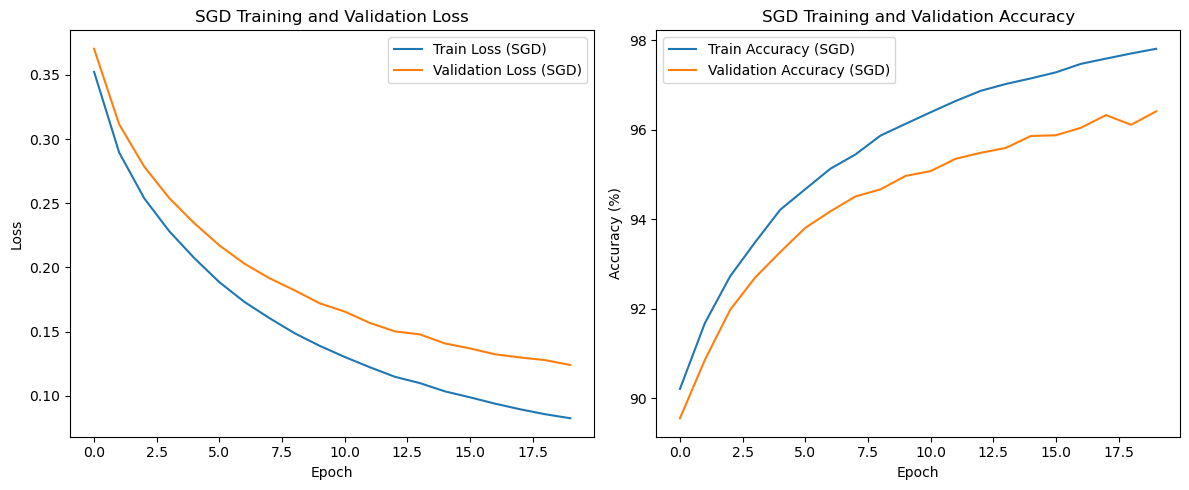

Test Loss: 2.3180, Test Acc: 11.61%
SGD Test Loss: 0.1043, SGD Test Acc: 96.75%


In [13]:
model_sgd = MultiLayerPerceptron()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

num_epochs_sgd = 20
train_losses_sgd, train_accuracies_sgd = [], []
val_losses_sgd, val_accuracies_sgd = [], []

for epoch in range(num_epochs_sgd):
    model.train()
    for images, labels in train_loader:
        optimizer_sgd.zero_grad()
        outputs = model_sgd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
    
    train_loss, train_acc = validate(model_sgd, train_loader, criterion)
    val_loss, val_acc = validate(model_sgd, val_loader, criterion)
    
    train_losses_sgd.append(train_loss)
    train_accuracies_sgd.append(train_acc)
    val_losses_sgd.append(val_loss)
    val_accuracies_sgd.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs_sgd}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

# Plot SGD training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(val_losses_sgd, label='Validation Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sgd, label='Train Accuracy (SGD)')
plt.plot(val_accuracies_sgd, label='Validation Accuracy (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SGD Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Evaluate the SGD model on the test set
test_loss_sgd, test_acc_sgd = validate(model_sgd, test_loader, criterion)
print(f"SGD Test Loss: {test_loss_sgd:.4f}, SGD Test Acc: {test_acc_sgd:.2f}%")

In [14]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First Convolutional Layer
        # Input: 1 channel (grayscale)
        # Output: 32 feature maps
        # Kernel size: 3x3
        self.conv1 = nn.Conv2d(in_channels=1, 
                              out_channels=32, 
                              kernel_size=3, 
                              stride=1, 
                              padding=1)
        
        # ReLU activation function
        self.relu = nn.ReLU()
        
        # First Max Pooling Layer
        # Reduces spatial dimensions by half
        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                   stride=2)
        
        # Second Convolutional Layer
        # Input: 32 channels (from prev layer)
        # Output: 64 feature maps
        # Kernel size: 3x3
        self.conv2 = nn.Conv2d(in_channels=32, 
                              out_channels=64, 
                              kernel_size=3, 
                              stride=1, 
                              padding=1)
        
        # Flatten layer to convert 2D feature maps to 1D vector
        self.flatten = nn.Flatten()
        
        # First Fully Connected Layer
        # Input: 64 * 7 * 7 (features after conv and pooling)
        # Output: 128 neurons
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        
        # Output Layer
        # Input: 128 neurons
        # Output: 10 classes (digits 0-9)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # First conv block
        # x shape: [batch_size, 1, 28, 28]
        x = self.conv1(x)         # -> [batch_size, 32, 28, 28]
        x = self.relu(x)          # -> [batch_size, 32, 28, 28]
        x = self.maxpool(x)       # -> [batch_size, 32, 14, 14]
        
        # Second conv block
        x = self.conv2(x)         # -> [batch_size, 64, 14, 14]
        x = self.relu(x)          # -> [batch_size, 64, 14, 14]
        x = self.maxpool(x)       # -> [batch_size, 64, 7, 7]
        
        # Flatten feature maps
        x = self.flatten(x)       # -> [batch_size, 64 * 7 * 7]
        
        # Fully connected layers
        x = self.fc1(x)           # -> [batch_size, 128]
        x = self.relu(x)          # -> [batch_size, 128]
        x = self.fc2(x)           # -> [batch_size, 10]
        
        return x

# Create model instance
model = SimpleCNN()

# Example of how tensor dimensions change through the network
batch_size = 4
example_input = torch.randn(batch_size, 1, 28, 28)
output = model(example_input)
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])


Epoch 1/20:
Train Loss: 0.2482, Train Acc: 92.36%
Val Loss: 0.2604, Val Acc: 92.08%

Epoch 2/20:
Train Loss: 0.1320, Train Acc: 96.16%
Val Loss: 0.1426, Val Acc: 95.81%

Epoch 3/20:
Train Loss: 0.1169, Train Acc: 96.36%
Val Loss: 0.1264, Val Acc: 96.09%

Epoch 4/20:
Train Loss: 0.0795, Train Acc: 97.64%
Val Loss: 0.0904, Val Acc: 97.38%

Epoch 5/20:
Train Loss: 0.0742, Train Acc: 97.78%
Val Loss: 0.0873, Val Acc: 97.40%

Epoch 6/20:
Train Loss: 0.0597, Train Acc: 98.18%
Val Loss: 0.0704, Val Acc: 97.83%

Epoch 7/20:
Train Loss: 0.0516, Train Acc: 98.47%
Val Loss: 0.0655, Val Acc: 98.07%

Epoch 8/20:
Train Loss: 0.0474, Train Acc: 98.63%
Val Loss: 0.0628, Val Acc: 98.08%

Epoch 9/20:
Train Loss: 0.0404, Train Acc: 98.77%
Val Loss: 0.0565, Val Acc: 98.22%

Epoch 10/20:
Train Loss: 0.0354, Train Acc: 98.97%
Val Loss: 0.0524, Val Acc: 98.52%

Epoch 11/20:
Train Loss: 0.0395, Train Acc: 98.81%
Val Loss: 0.0580, Val Acc: 98.21%

Epoch 12/20:
Train Loss: 0.0350, Train Acc: 98.90%
Val Loss: 0.

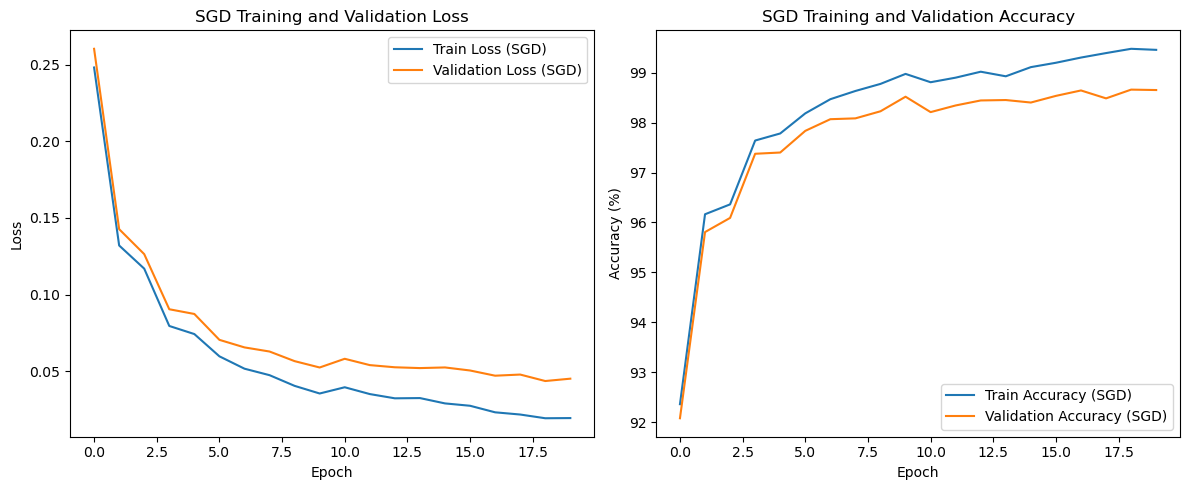

Test Loss: 2.3133, Test Acc: 9.48%
SGD Test Loss: 0.0328, SGD Test Acc: 98.86%


In [15]:
model_sgd = SimpleCNN()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

num_epochs_sgd = 20
train_losses_sgd, train_accuracies_sgd = [], []
val_losses_sgd, val_accuracies_sgd = [], []

for epoch in range(num_epochs_sgd):
    model.train()
    for images, labels in train_loader:
        optimizer_sgd.zero_grad()
        outputs = model_sgd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
    
    train_loss, train_acc = validate(model_sgd, train_loader, criterion)
    val_loss, val_acc = validate(model_sgd, val_loader, criterion)
    
    train_losses_sgd.append(train_loss)
    train_accuracies_sgd.append(train_acc)
    val_losses_sgd.append(val_loss)
    val_accuracies_sgd.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs_sgd}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

# Plot SGD training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(val_losses_sgd, label='Validation Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sgd, label='Train Accuracy (SGD)')
plt.plot(val_accuracies_sgd, label='Validation Accuracy (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SGD Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Evaluate the SGD model on the test set
test_loss_sgd, test_acc_sgd = validate(model_sgd, test_loader, criterion)
print(f"SGD Test Loss: {test_loss_sgd:.4f}, SGD Test Acc: {test_acc_sgd:.2f}%")